[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)

Asian-option pricing using 2D advection-diffusion solver   
MSc project by Paweł Magnuszewski (pmagnus@student.agh.edu.pl)

TODO:
- zero-strike option test
- Monte-Carlo
- rhs: the maximum call should best not be needed
- case with nx != ny

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"

In [3]:
from types import SimpleNamespace
from functools import lru_cache, cached_property

import numpy as np
import numba
from matplotlib import pyplot, colors
from pystrict import strict
from ipywidgets import IntProgress
from tqdm import tqdm

from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA.impl.traversals_common import make_fill_halos_loop
from PyMPDATA import Options, ScalarField, Solver, Stepper, VectorField
from PyMPDATA.boundary_conditions import Extrapolated, Constant
from PyMPDATA.impl.enumerations import SIGN_RIGHT, ARG_FOCUS, META_AND_DATA_META, META_AND_DATA_DATA, OUTER, INNER
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic
from PyMPDATA_examples.utils.financial_formulae import Black_Scholes_1973, Bjerksund_and_Stensland_1993
from PyMPDATA_examples.utils.quick_look import quick_look
from monte_carlo import BSModel, FixedStrikeGeometricAsianOption, FixedStrikeArithmeticAsianOption

In [4]:
OPTIONS = {
    "n_iters": 3,
    "infinite_gauge": False,
    "nonoscillatory": True,
    "divergent_flow": False,
    "third_order_terms": False,
    "non_zero_mu_coeff": True,
}

In [5]:
@strict
class Settings:
    params = SimpleNamespace(
        T=2,
        sgma=0.1,
        r=.1,
        K1=80,
        K2=100,
    )

    S_min = 50
    S_max = 200
    
    def payoff(self, A: np.ndarray):
        # payoff1 = np.maximum(0, self.params.K1-A)
        # payoff2 = np.maximum(0, self.params.K2-A)
        call1 = np.maximum(0, A - self.params.K2)
        # call2 = np.maximum(0, A - self.params.K1)
        # call_corridor = np.maximum(0, A - self.params.K1) - np.maximum(0, A - self.params.K2)
        # return call_corridor
        return call1
        # return payoff2 - payoff1

In [6]:
_t = np.nan

@lru_cache()
# pylint: disable=too-many-arguments
def _make_scalar_custom(dim, eps, ats, set_value, halo, dtype, jit_flags, data, inner_or_outer, S_max, dx, T):
    @numba.njit(**jit_flags)
    def impl(focus_psi, span, sign):
        focus = focus_psi[0]
        i = min(max(0, focus[inner_or_outer] - halo), span - 1)
        if sign == SIGN_RIGHT:
            edg = span + halo - 1 - focus_psi[ARG_FOCUS][dim]
            den = ats(*focus_psi, edg - 1) - ats(*focus_psi, edg - 2)
            nom = ats(*focus_psi, edg) - ats(*focus_psi, edg - 1)
            cnst = nom / den if abs(den) > eps else 0
            return max(
                ats(*focus_psi, -1) + (ats(*focus_psi, -1) - ats(*focus_psi, -2)) * cnst, 0
            )
        return data[i]
    
    if dtype == complex:
        @numba.njit(**jit_flags)
        def fill_halos_scalar(psi, span, sign):
            return complex(
                impl(
                    (psi[META_AND_DATA_META], psi[META_AND_DATA_DATA].real), span, sign
                ),
                impl(
                    (psi[META_AND_DATA_META], psi[META_AND_DATA_DATA].imag), span, sign
                ),
            )
    else:
        @numba.njit(**jit_flags)
        def fill_halos_scalar(psi, span, sign):
            return impl(psi, span, sign)

    return make_fill_halos_loop(jit_flags, set_value, fill_halos_scalar)


class KemnaVorstBoundaryCondition(Extrapolated):
    def __init__(self, *, data_left, T, dx, S_max, dim):
        super().__init__(dim=dim)
        self.data = tuple(data_left)
        self.inner_or_outer = (INNER, OUTER)[dim]
        self.S_max = S_max
        self.dx = dx
        self.T = T

    def make_scalar(self, indexers, halo, dtype, jit_flags, dimension_index):
        return _make_scalar_custom(
            self.dim,
            self.eps,
            indexers.ats[dimension_index],
            indexers.set,
            halo,
            dtype,
            jit_flags,
            self.data,
            self.inner_or_outer,
            S_max=self.S_max,
            dx=self.dx,
            T=self.T,
        )

In [7]:
class Simulation:
    def __init__(self, settings, *, nx, ny, nt):
        self.nx = nx
        self.nt = nt
        
        self.ny = ny
        self.dt = settings.params.T / self.nt
        log_s_min = np.log(settings.S_min)
        log_s_max = np.log(settings.S_max)
        self.S = np.exp(np.linspace(log_s_min, log_s_max, self.nx))
        self.A, self.dy = np.linspace(0, settings.S_max, self.ny, retstep=True)
        self.dx = (log_s_max - log_s_min) / self.nx
        # self.dy =

        self.settings = settings
        self.step_number = 0
        
        sigma_squared = pow(settings.params.sgma, 2)
        courant_number_x = -(0.5 * sigma_squared - settings.params.r) * (-self.dt) / self.dx
        
        self.l2 = self.dx * self.dx / sigma_squared / self.dt
        
        self.mu_coeff = (0.5 / self.l2, 0)
        
        assert self.l2 > 2, f"Lambda squared should be more than 2 for stability {self.l2}"
        
        print(f"dx: {self.dx}, dy: {self.dy}, dt: {self.dt}, l2: {self.l2}")

        self.payoff = settings.payoff(A=self.A)
        
        options = Options(**OPTIONS)
        stepper = Stepper(options=options, n_dims=2)

        x_dim_advector = np.full(
            (self.nx + 1, self.ny),
            courant_number_x,
            dtype=options.dtype,
        )
        print(f"CFL {np.max(np.abs(self.a_dim_advector)) + np.max(np.abs(x_dim_advector))}")
        assert np.max(np.abs(self.a_dim_advector)) + np.max(np.abs(x_dim_advector)) < 1, f"CFL condition not met {np.max(np.abs(self.a_dim_advector)) + np.max(np.abs(x_dim_advector))}"
        
        print(f"{x_dim_advector.shape=}, {self.a_dim_advector.shape=}")

        self.solver = Solver(
            stepper=stepper,
            advectee=ScalarField(
                self.payoff_2d.astype(dtype=options.dtype) * np.exp(-self.settings.params.r * self.settings.params.T),
                halo=options.n_halo,
                boundary_conditions=self.boundary_conditions,
            ),
            advector=VectorField(
                (x_dim_advector, self.a_dim_advector),
                halo=options.n_halo,
                boundary_conditions=self.boundary_conditions,
            ),
        )
        self.rhs = np.zeros((self.nx, self.ny))
    
    @property
    def a_dim_advector(self):
        raise NotImplementedError()

    def add_half_rhs(self):
        raise NotImplementedError()

    def free_boundary(self, t):
        raise NotImplementedError()

    def step(self):
        global _t
        _t = settings.params.T - (self.step_number + 0.5) * self.dt
        
        self.add_half_rhs()
        self.free_boundary(t=_t)

        self.solver.advance(1, self.mu_coeff)

        self.add_half_rhs()
        self.free_boundary(t=_t)

        self.step_number += 1

class _Asian(Simulation):
    @cached_property
    def payoff_2d(self):
        return np.repeat([self.payoff], self.nx, axis=0)
    def free_boundary(self, t):
        pass
    @cached_property
    def boundary_conditions(self):
        return (
            KemnaVorstBoundaryCondition(
                data_left=self.payoff_2d[0,:] * np.exp(-self.settings.params.r * self.settings.params.T),
                dim=OUTER,
                dx=self.dx,
                S_max=self.settings.S_max,
                T=self.settings.params.T,
            ),
            Extrapolated(INNER),
        )

class AsianArithmetic(_Asian):
    @property
    def a_dim_advector(self):
        a_dim_advector = np.zeros((self.nx, self.ny + 1))
        # y_edg = np.log(self.S[0]) + np.arange(self.ny + 1) * self.dy
        # A_edg = np.exp(y_edg - self.dy / 2)
        for i in range(self.ny + 1):
            a_dim_advector[:, i] = -self.dt / self.dy * self.S / self.settings.params.T
        return a_dim_advector
    def add_half_rhs(self):
        pass
        # psi = self.solver.advectee.get()
        # self.rhs[:] = -psi / self.settings.params.T # todo male t
        # psi[:] = np.maximum(0, psi + -self.dt * self.rhs / 2) 
    
class AsianGeometric(_Asian):
    @property
    def a_dim_advector(self):
        a_dim_advector = np.zeros((self.nx, self.ny + 1))
        # y_edg = np.log(self.S[0]) + np.arange(self.ny + 1) * self.dy
        # A_edg = np.exp(y_edg - self.dy / 2)
        A_edg = np.arange(self.ny + 1) * self.dy
        for i in range(self.ny + 1):
            a_dim_advector[:, i] = -self.dt / self.dy * np.log(self.S) * (A_edg[i] - self.dy/2) / self.settings.params.T 
        return a_dim_advector
    def add_half_rhs(self):
        pass
        # psi = self.solver.advectee.get()
        # self.rhs[:] = psi / self.settings.params.T * np.log(self.S)
        # psi[:] = np.maximum(0, psi + -self.dt * self.rhs / 2) 

class European(Simulation):
    @cached_property
    def a_dim_advector(self):
        return np.zeros((self.nx, self.ny + 1))
    def add_half_rhs(self):
        pass
    @cached_property
    def payoff_2d(self):
        return np.repeat(self.payoff.reshape(self.nx, 1), self.ny, axis=1)
    def free_boundary(self, t):
        pass
    @cached_property
    def boundary_conditions(self):
        return (
            Extrapolated(OUTER),
            Extrapolated(INNER),
        )
class American(European):
    def free_boundary(self, t):
        psi = self.solver.advectee.get()
        psi[:] = np.maximum(psi, self.payoff_2d / np.exp(settings.params.r * t)) 

In [8]:
settings = Settings()
simulations = {
    # 'European': European(settings, nx=30, nt=120),
    # 'American': American(settings, nx=30, nt=120),
    'Asian arithmetic': AsianArithmetic(settings, nx=31, ny=41, nt=150),
    # 'Asian geometric': AsianGeometric(settings, nx=31, ny=41, nt=300),
}

dx: 0.0447191729393513, dy: 5.0, dt: 0.013333333333333334, l2: 14.998533212847066
CFL 0.2949915793027866
x_dim_advector.shape=(32, 41), self.a_dim_advector.shape=(31, 42)


In [9]:
def plot_advectee(advectee_array, fig, ax, normargs, t=settings.params.T, colorbar_shrink=.91):
    fig.colorbar(ax.imshow(
        advectee_array,
        extent=(np.log(settings.S_min), np.log(settings.S_max), np.log(settings.S_min), np.log(settings.S_max)),
        origin="lower",
        norm=colors.Normalize(**normargs)
    ), shrink=colorbar_shrink)

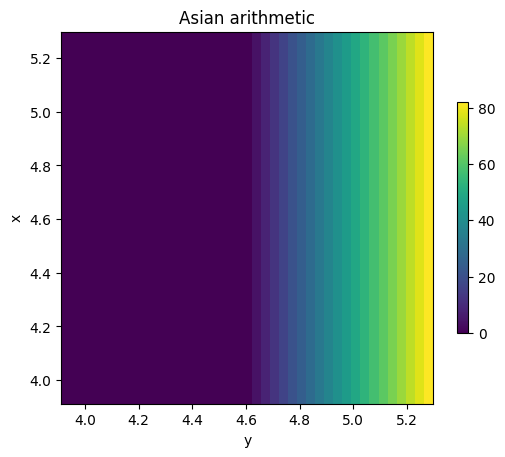

In [21]:
fig, axs = pyplot.subplot_mosaic([simulations.keys()], figsize=(6 * len(simulations), 6))
for key, simulation in simulations.items():
    psi = simulation.solver.advectee.get()
    plot_advectee(psi, fig, axs[key], normargs={'vmin':np.amin(psi), 'vmax':np.amax(psi)}, colorbar_shrink=.5)
    axs[key].set_title(key)
    axs[key].set_xlabel("y")
    axs[key].set_ylabel("x")
show_plot('terminal_condition.pdf', inline_format='png')

In [ ]:
# quick_look(simulations['Asian geometric'].solver.advector)

grid=(41, 31), scale=0.2666666666666666


ValueError: Argument V has a size 1312 which does not match 1302, the number of arrow positions

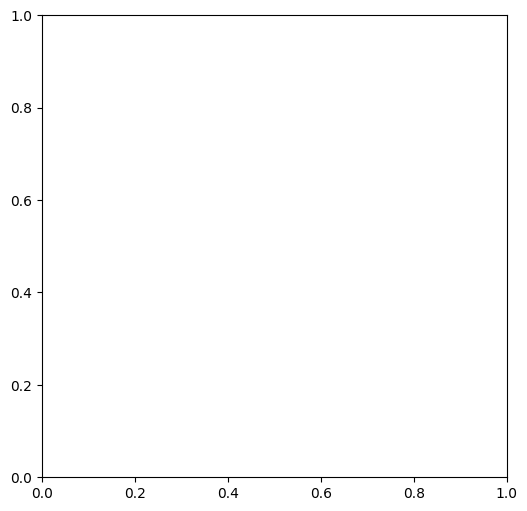

In [113]:
fig, axs = pyplot.subplot_mosaic([simulations.keys()], figsize=(6 * len(simulations), 6))
for key, simulation in simulations.items():
    X = simulation.solver.advector.get_component(0)
    Y = simulation.solver.advector.get_component(1)
    grid = (X.shape[1], Y.shape[0])
    scale = max(np.amax(np.abs(X)), np.amax(np.abs(Y)))
    print(f"{grid=}, {scale=}")
    axs[key].quiver(*np.mgrid[
            1 / 2 : grid[1] : 1,
            0: grid[0]+1 : 1,
        ], 0, X.T.flatten()/scale, pivot='mid', color='green', width=.005,
        label='price advector values at cell walls', scale=1, scale_units='inches'
    )
    axs[key].quiver(*np.mgrid[
            0: grid[1]+1 : 1,
            1 / 2 : grid[0] : 1,
        ], Y.T.flatten()/scale, 0, pivot='mid', color='blue', width=.005,
        label='averaging advector values at cell walls', scale=1, scale_units='inches'
    )
    axs[key].scatter(*np.mgrid[
            1/2: grid[1] : 1,
            1/2: grid[0] : 1
        ], color='red', label='cell centers', s=2
    )
    
    axs[key].axis('equal')
    axs[key].set_title(key)
    axs[key].set_xlabel('y/Δy')
    axs[key].set_ylabel('x/Δx')
    # axs[key].legend(bbox_to_anchor=(.1, -.1), loc='upper left', ncol=1)
    for i, xy in enumerate(('x', 'y')):
        getattr(axs[key], f"set_{xy}ticks")(np.arange(0, grid[i] + 1))
    axs[key].grid()
show_plot('advector.pdf')

In [10]:
history = {}
for key, simulation in simulations.items():
    history[key] = []
    print(f"{key}: {simulation.nt} time steps will be taken")
    progbar = IntProgress(max = simulation.nt)
    display(progbar)
    
    for progbar.value in range(simulation.nt + 1):
        if progbar.value != 0:
            res = simulation.step()
        history[key].append(simulation.solver.advectee.get().copy())

Asian arithmetic: 150 time steps will be taken


IntProgress(value=0, max=150)

In [14]:
arithmetic_by_mc = np.zeros_like(simulation.S)
arithmetic_option = FixedStrikeArithmeticAsianOption(settings.params.T, settings.params.K2, 'call')
for idx, spot in tqdm(enumerate(simulation.S)):
    model = BSModel(spot, settings.params.r, settings.params.sgma, settings.params.T, 1000)
    arithmetic_by_mc[idx] = arithmetic_option.price_by_mc(model, 100000)

Pricing by MC: 100%|█████████████████████████████████████| 100000/100000 [00:04<00:00, 21318.46it/s]


In [19]:
def plot_solution(frame_index, ax, history, option_type: str):
    params = {k:v for k,v in settings.params.__dict__.items() if not k.startswith("K")}

    ax.plot(
        simulation.S,
        (
            Black_Scholes_1973.c_euro(S=simulation.S, K=settings.params.K2, **params, b=settings.params.r)
            # -
            # Black_Scholes_1973.c_euro(S=simulation.S, K=settings.params.K2, **params, b=settings.params.r)
        ),
        label="European analytic (Black-Scholes '73)", linestyle=':'
    )
    # ax.plot(
    #     simulation.S,
    #     (
    #         Bjerksund_and_Stensland_1993.c_amer(S=simulation.S, K=settings.params.K2, **params, b=settings.params.r)
    #         # -
    #         # Bjerksund_and_Stensland_1993.c_amer(S=simulation.S, K=settings.params.K2, **params, b=settings.params.r)
    #     ),
    #     label="American analytic (Bjerksund & Stensland '93)", linestyle='--'
    # )
    ax.plot(
        simulation.S,
        (
            asian_analytic.geometric_asian_average_price_c(
                S=simulation.S,
                K=settings.params.K2,
                **params,
                dividend_yield=0
            )
        ),
        label="Asian analytic (geometric, Kemna & Vorst 1990)", alpha=0.5, linestyle="--"
    )
    
    ax.plot(
        simulation.S,
        arithmetic_by_mc,
        label="Asian arithmetic by Monte-Carlo"
    )
    ax.plot(simulation.S, history[frame_index][:,0], label=f"MPDATA solution ({option_type})", marker='.')
    # ax.plot(simulation.S, history[0].diagonal(), label="discretised terminal condition (discounted payoff)", marker='.', alpha=0.5)
    ax.legend(loc='upper right')
    ax.grid()
    minmax = (np.amin(history[0]), np.amax(history[0]))
    span = minmax[1] - minmax[0]
    ax.set_ylim(minmax[0] - .05 * span, minmax[1] + .25 * span)
    ax.set_title(f"instrument parameters: {settings.params.__dict__}")
    ax.set_xlabel("underlying S(t=0)=A(t=0) (and A(T) for terminal condition)")
    ax.set_ylabel("option price")
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_ylim(10e-1, 100)
    # ax.set_xlim(95, 105)

In [40]:
def plot_difference_arithmetic(frame_index, ax, history, option_type: str):
    params = {k:v for k,v in settings.params.__dict__.items() if not k.startswith("K")}

    
    ax.plot(
        simulation.S,
        abs(arithmetic_by_mc-history[frame_index][:,0])/arithmetic_by_mc,
        label="Difference in price of Asian arithmetic option MPDATA vs MC"
    )
    # ax.plot(simulation.S, history[frame_index][:,0], label=f"MPDATA solution ({option_type})", marker='.')
    # ax.plot(simulation.S, history[0].diagonal(), label="discretised terminal condition (discounted payoff)", marker='.', alpha=0.5)
    ax.legend(loc='upper right')
    ax.grid()
    # minmax = (np.amin(history[0]), np.amax(history[0]))
    # span = minmax[1] - minmax[0]
    # ax.set_ylim(minmax[0] - .05 * span, minmax[1] + .25 * span)
    ax.set_title(f"instrument parameters: {settings.params.__dict__}")
    ax.set_xlabel("underlying S(t=0)=A(t=0) (and A(T) for terminal condition)")
    ax.set_ylabel("option price")
    ax.set_yscale('log')
    # ax.set_xscale('log')
    # ax.set_ylim(10e-1, 100)
    # ax.set_xlim(95, 105)

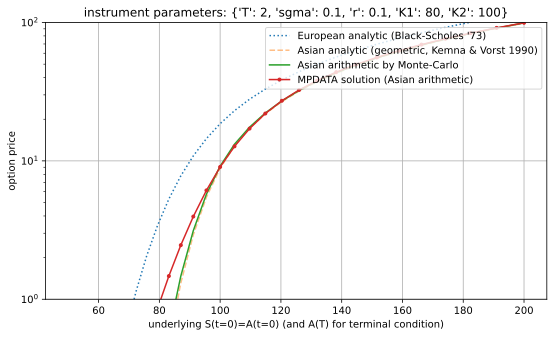

In [38]:
fig, axs = pyplot.subplot_mosaic([simulations.keys()], figsize=(9 * len(simulations), 5))
for key, simulation in simulations.items():
    plot_solution(-1, axs[key], history[key], option_type=key)
show_plot('numeric_vs_analytic.pdf')

C:\Users\Pawel\AppData\Local\Temp\ipykernel_10108\579043887.py:7: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc-history[frame_index][:,0])/arithmetic_by_mc,


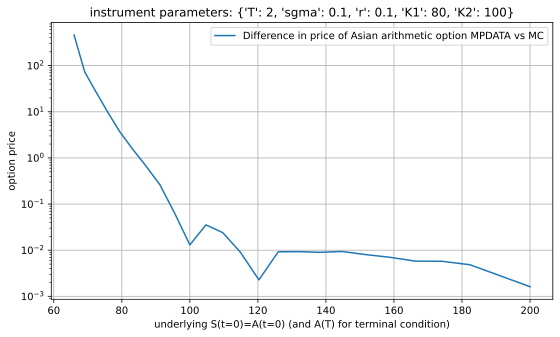

In [41]:
fig, axs = pyplot.subplot_mosaic([simulations.keys()], figsize=(9 * len(simulations), 5))
for key, simulation in simulations.items():
    plot_difference_arithmetic(-1, axs[key], history[key], option_type=key)
show_plot('numeric_vs_analytic.pdf')

In [26]:
def option_price_at_s(spot, diagonal):
    return np.interp(spot, simulation.S, diagonal)

In [29]:
# zvan_val = 3.100
# lower_bound = 3.1004
analytic = asian_analytic.geometric_asian_average_price_c(
                S=140,
                K=settings.params.K2,
                sgma=settings.params.sgma,
                r=settings.params.r,
                T=settings.params.T,
                dividend_yield=0
            ) 
# print("from article:", zvan_val)
print("Asian analytic (geometric) at S=100:", analytic)
# print("MPDATA (geometric) at S=100:", option_price_at_s(100, history['Asian geometric'][-1].diagonal()))
print("MPDATA (arithmetic) at S=100:", option_price_at_s(100, history['Asian arithmetic'][-1][:,0]))


Asian analytic (geometric) at S=100: 44.59321040308626
MPDATA (arithmetic) at S=100: 9.038593511975286


IntProgress(value=0, max=151)


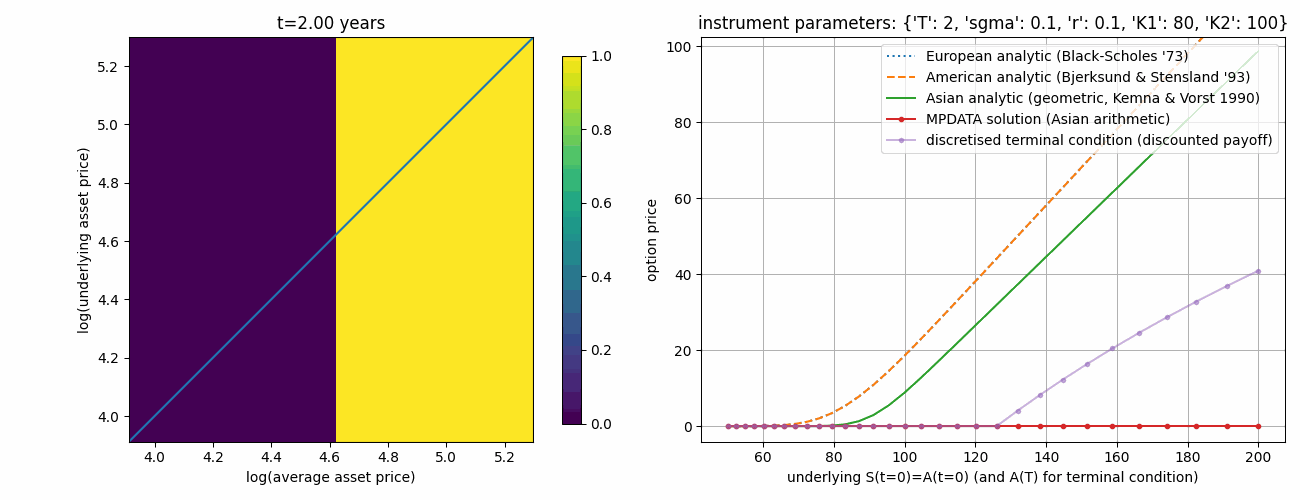

HTML(value="<a href='.\\tmpqu48160_.gif' target='_blank'>.\\tmpqu48160_.gif</a><br>")

In [28]:
for key, simulation in simulations.items():
    progbar = IntProgress(max = simulation.nt+1)
    
    def generate_anim_frame(frame_index):
        progbar.value = frame_index
        fig, axs = pyplot.subplots(1, 2, figsize=(13, 5))
        plot_advectee(
            history[key][frame_index],
            fig, axs[0],
            t=settings.params.T - frame_index * simulation.dt,
            normargs={'vmin':0, 'vmax':1}#np.amax(history['American'][-1])}
        )
        axs[0].plot([np.log(settings.S_min), np.log(settings.S_max)], [np.log(settings.S_min), np.log(settings.S_max)])
        plot_solution(frame_index, axs[1], history[key], option_type=key)
        axs[0].set_title(f"t={settings.params.T - frame_index * simulation.dt:.2f} years")
        axs[0].set_xlabel("log(average asset price)")
        axs[0].set_ylabel("log(underlying asset price)")
        fig.tight_layout()
        fig.savefig(f'animation/{key}/frame_{frame_index//10}.pdf')
        return fig
    
    display(progbar)
    show_anim(generate_anim_frame, range(0, len(history[key]), len(history[key])//10), duration=0.01, loop=0)